#### Jupyter Notebook to use ensembles for segmentation prediction


#### Imports

In [30]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
%matplotlib inline

#### Path to change (put path to image to segment)

In [31]:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'

#### Set paths for AxonDeepSeg segmentation tools

In [32]:
img = imageio.imread(path_img)
path_folder, file_name = os.path.split(path_img)

model_name = 'default_SEM_model_v1'
path_model = os.path.join('..','AxonDeepSeg','models',model_name)
path_configfile = os.path.join(path_model,'config_network.json')
with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
mask = imread(os.path.join(path_folder,'mask.png'),flatten=True)
#mask = imageio.imread(os.path.join(path_folder,'mask.png'))
gt_axon = mask > 200
gt_myelin = np.logical_and(mask >= 50, mask <= 200)

#### 1) Explore various values of patch overlap for prediction and plot axon and myelin Dice metrics for each

In [36]:
values = np.linspace(5,100,20) # Using overlap values from 5 to 100 pixels
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
img_array = []
pred_array = []

for value_percentage in values:
    
    # Generate subfolders for ensembles
    directory_name = 'image_' + str(int(value_percentage))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'image.png'), os.path.join(path_folder,directory_name))

    # Segment with AxonDeepSeg using different overlap for prediction
    path_testing = os.path.join(path_folder,directory_name)
    prediction = axon_segmentation(path_testing, file_name, path_model, config_network,overlap_value=int(value_percentage),verbosity_level=0)
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

#### Plots

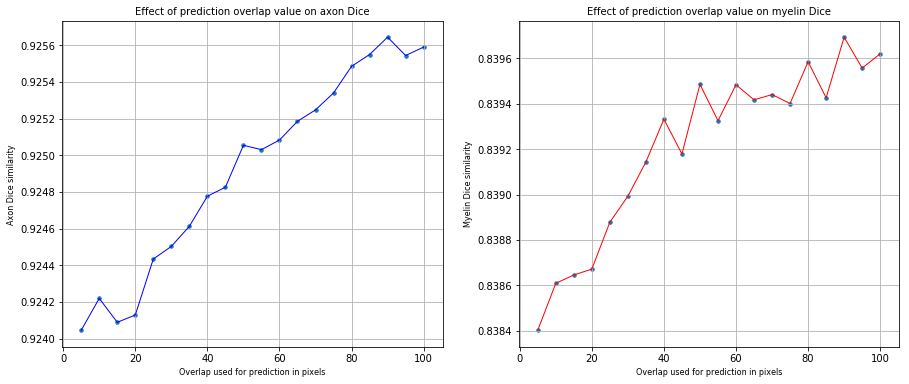

In [47]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(values, dice_axon_array, 'b', lw=1)
plt.scatter(values, dice_axon_array, s=12)
plt.xlabel('Overlap used for prediction in pixels',fontsize=8)
plt.ylabel('Axon Dice similarity',fontsize=8)
plt.title('Effect of prediction overlap value on axon Dice',fontsize=10)
plt.grid(True)

plt.subplot(122)
plt.plot(values, dice_myelin_array, 'r', lw=1)
plt.scatter(values, dice_myelin_array, s=12)
plt.xlabel('Overlap used for prediction in pixels',fontsize=8)
plt.ylabel('Myelin Dice similarity',fontsize=8)
plt.title('Effect of prediction overlap value on myelin Dice',fontsize=10)
plt.grid(True)



(5,)


In [ ]:
def majority_vote:
    

In [43]:

prediction[:,:,1]=img

In [83]:
values = np.linspace(25,85,2) # Using overlap values of 25, 40, 55, 70 and 85

y, x = img.shape
predictions_array = np.empty([y,x])
tmp = np.empty([y,x])
dice_axon_array = np.empty(0)
dice_myelin_array = np.empty(0)
img_array = []
pred_array = []
i = 1

for value_percentage in values:
    
    # Generate subfolders for ensembles
    directory_name = 'image_' + str(int(value_percentage))
    os.makedirs(os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), os.path.join(path_folder,directory_name))
    copy(os.path.join(path_folder,'image.png'), os.path.join(path_folder,directory_name))

    # Segment with AxonDeepSeg using different overlap for prediction
    path_testing = os.path.join(path_folder,directory_name)
    if i == 1:
        predictions_array = axon_segmentation(path_testing, file_name, path_model, config_network,overlap_value=int(value_percentage),verbosity_level=0)
    else:
        tmp = axon_segmentation(path_testing, file_name, path_model, config_network,overlap_value=int(value_percentage),verbosity_level=0)
        np.append(predictions_array,tmp,axis=2)
    i = i+1
    
    # Compute prediction accuracy
    prediction = imread(os.path.join(path_folder,directory_name,'AxonDeepSeg.png'),flatten=True)
    pred_axon = prediction > 200
    pred_myelin = np.logical_and(prediction >= 50, prediction <= 200)
    dice_axon, dice_myelin = pw_dice(pred_axon, gt_axon),pw_dice(pred_myelin, gt_myelin)
    dice_axon_array = np.append(dice_axon_array, [dice_axon], axis=0)
    dice_myelin_array = np.append(dice_myelin_array, [dice_myelin], axis=0)
    dict_metrics = {'dice_axon': dice_axon, 'dice_myelin': dice_myelin}
    f = open(os.path.join(path_folder,directory_name,'metrics.txt'), 'w')
    f.write('segmentation metrics: ' + repr(dict_metrics) + '\n')
    f.close()

In [93]:
pred_array = []
pred_array.append(predictions_array)
print pred_array
plt.imshow(pred_array[1], cmap='gray')

[[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 2, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]]


IndexError: list index out of range

In [86]:
print tmp.shape
print predictions_array.shape
a = np.dstack((tmp,predictions_array))
print a.shape

AttributeError: 'list' object has no attribute 'shape'

In [74]:
np.append(predictions_array,tmp,axis=2)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 2, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [76]:
print tmp

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 2, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


In [55]:
import numpy as np
from scipy import stats

a = np.array([[1, 3, 4, 2, 2, 7],
              [5, 2, 2, 1, 4, 1],
              [3, 3, 2, 2, 1, 1]])

m = stats.mode(a)
print(m)

ModeResult(mode=array([[1, 3, 2, 2, 1, 1]]), count=array([[1, 2, 2, 2, 1, 2]]))


In [67]:
y, x = img.shape
predictions_array = np.empty([y,x,values.size])

In [ ]:
label_img = label(image)
regions = regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

In [9]:
text_file = open(os.path.join(path_folder,'pixel_size_in_micrometer.txt'), "r")
pixelsize = float(text_file.read())
print pixelsize
text_file.close()

0.07


In [10]:
from skimage import measure
from skimage.measure import regionprops

In [11]:
y0_array = np.empty(0)
x0_array = np.empty(0)
solidity_array = np.empty(0)
axon_diam_array = np.empty(0)
eccentricity_array = np.empty(0)
orientation_array = np.empty(0)

labels = measure.label(pred_axon)
axon_objects = regionprops(labels)

for props in axon_objects:
    y0, x0 = props.centroid
    solidity = props.solidity
    axon_diam = (props.equivalent_diameter)*pixelsize
    eccentricity = props.eccentricity
    orientation = props.orientation
    
    y0_array, x0_array = np.append(y0_array, [y0], axis=0), np.append(x0_array, [x0], axis=0)
    solidity_array = np.append(solidity_array, [solidity], axis=0)
    axon_diam_array = np.append(axon_diam_array, [axon_diam], axis=0)
    eccentricity_array = np.append(eccentricity_array, [eccentricity], axis=0)
    orientation_array = np.append(orientation_array, [orientation], axis=0)

In [12]:
print(eccentricity_array)

[0.97397205 0.59872592 0.85264365 0.54521293 0.85012389 0.96799732
 0.9332649  0.80251021 0.69163051 0.4595592  0.36499071 0.64526954
 0.99435853 0.4276116  0.66267476 0.74481732 0.7537881  0.66734708
 0.69468707 0.83702675 0.71087046 0.90049286 0.76127654 0.24212429
 0.52934637 0.5731145  0.91746269 0.88271063 0.79417209 0.41143672
 0.77167017 0.95677734 0.32156826 0.68756627 0.86002313 0.65878367
 0.86878162 0.75290368 0.78190141 0.6228777  0.84799947 0.77228628
 0.76704484 0.73235662 0.35605824 0.69259315 0.58034187 0.83356823
 0.57924506 0.68978957 0.94182761 0.14567687 0.50160454 0.7238846
 0.66059231 0.75496385 0.87904907 0.6160409  0.60961752 0.73409601
 0.62705651 0.67698807 0.82107824 0.65960494 0.69223926 0.82580565
 0.89570709 0.44429326 0.77444678 0.62147995 0.59475636 0.7579281
 0.78438456 0.86017577 0.54993129 0.84459281 0.7416617  0.81971776
 0.7954219  0.85152324 0.67100703 0.92549127 0.63554199 0.55761907
 0.76862257 0.88407467 0.67480695 0.85101905 0.79881255 0.873038

In [14]:
stats_array = np.empty(0)

labels = measure.label(pred_axon)
axon_objects = regionprops(labels)

for props in axon_objects:
    
    y0, x0 = props.centroid
    solidity = props.solidity
    axon_diam = (props.equivalent_diameter)*pixelsize
    eccentricity = props.eccentricity
    orientation = props.orientation
    
    stats = {'y0': y0, 'x0': x0, 'axon_diam': axon_diam, 'solidity':solidity,'eccentricity': eccentricity,'orientation':orientation}
    stats_array = np.append(stats_array, [stats], axis=0)

In [15]:
print stats_array

[{'axon_diam': 1.6995877603526874, 'solidity': 0.9605809128630706, 'eccentricity': 0.9739720454622895, 'y0': 5.280777537796976, 'x0': 116.99352051835854, 'orientation': -0.02154700130228092}
 {'axon_diam': 5.879591784737265, 'solidity': 0.9556743704725768, 'eccentricity': 0.598725922136262, 'y0': 38.27070925825663, 'x0': 375.78758346868796, 'orientation': 0.008787173355709247}
 {'axon_diam': 0.4804563762304389, 'solidity': 0.9736842105263158, 'eccentricity': 0.8526436522962013, 'y0': 2.6486486486486487, 'x0': 501.56756756756755, 'orientation': 0.19540410523111157}
 {'axon_diam': 2.2088004182171366, 'solidity': 0.9524969549330086, 'eccentricity': 0.5452129293957123, 'y0': 16.26086956521739, 'x0': 542.5063938618925, 'orientation': 1.2664503657580028}
 {'axon_diam': 8.957227063770436, 'solidity': 0.8755446623093682, 'eccentricity': 0.8501238945995111, 'y0': 45.31609642301711, 'x0': 692.699066874028, 'orientation': 0.11319795493544006}
 {'axon_diam': 1.744869737078021, 'solidity': 0.943907

In [16]:
print stats.keys()

['axon_diam', 'solidity', 'eccentricity', 'y0', 'x0', 'orientation']


In [17]:
# Get axon diameter value of axon object 0
print stats_array[0]['axon_diam']

1.69958776035


In [18]:
# Get all stats for axon object 0
print stats_array[0]

{'axon_diam': 1.6995877603526874, 'solidity': 0.9605809128630706, 'eccentricity': 0.9739720454622895, 'y0': 5.280777537796976, 'x0': 116.99352051835854, 'orientation': -0.02154700130228092}


In [19]:
# Get axon diameter value of all axons in list
axon_diam_list = [d['axon_diam'] for d in stats_array]

In [20]:
# Get number of axons
print np.size(axon_diam_list)

296


In [21]:
# Get mean diameter
mean_diam = np.mean(axon_diam_list)
print mean_diam

2.572955000815824


In [127]:
import csv

with open(os.path.join(path_folder,'stats.csv'), 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(stats_array)


In [128]:
import csv
toCSV = stats_array
keys = toCSV[0].keys()
with open(os.path.join(path_folder,'stats.csv'), 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(toCSV)

In [129]:
with open(os.path.join(path_folder,'stats.csv'), 'wb') as output:
    writer = csv.writer(output)
    for each in stats_array:
        for key, value in each.iteritems():
            writer.writerow([key, value])

In [133]:
class Axon:
    def __init__(self,x0=None,y0=None,axon_diam=None):
        self.__x0=x0
        self.__y0=y0
        self.__axon_diam=axon_diam
    def getDiameter(self):
        return self.__axon_diam
    def getPosx(self):
        return self.__x0
    def getPosy(self):
        return self.__y0
    def __hash__(self):
        return hash((self.__axon_diam,self.__x0,self.__y0))
    def __eq__(self, other):
        return self.__axon_diam,self.__x0,self.__y0==other.__axon_diam,other.__x0,other.__y0
    def toArray(self):
        return [self.__x0,
            self.__y0,
            self.__axon_diam]

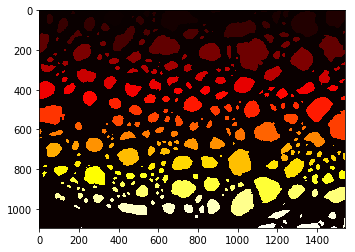

In [29]:
labels = measure.label(pred_axon)
axon_objects = regionprops(labels)



plt.imshow(labels,cmap='hot')

imageio.imwrite('aaa.png', labels)


In [171]:
labels(1150,600)

TypeError: 'numpy.ndarray' object is not callable

In [172]:
print np.min(labels)

0


In [23]:


axon_diam_list = [d['axon_diam'] for d in stats_array]

axon_iter = np.arange(np.size(axon_diam_list))


for pix_x in np.arange(np.shape(labels)[0]):
       for pix_y in np.arange(np.shape(labels)[1]):
            labels[pix_x,pix_y] = axon_diam_list[labels[pix_x,pix_y]]




IndexError: list index out of range

In [25]:
labels==2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
axon_iter = np.arange(np.size(axon_diam_list))

In [24]:
np.size(pred_axon)

1688936